In [1]:
import torch
from torch import nn
import time
import torchtext
import numpy as np

import random

from collections import defaultdict, Counter

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

import pandas as pd

In [2]:
embvec = torchtext.vocab.GloVe(name='840B', dim=300,cache='/home/pding/Documents/glove/')

In [3]:
import spacy
import en_core_web_sm
svoc = spacy.load("en_core_web_sm")

In [148]:
datatrain

,SRC,TRG,keywords,ext perc
32460167,Clinical implications of serum neurofilament i...,O O O O O O O O O O O O O O O O O O O O O O B ...,"[Biomarker, Multiple sclerosis, Neurofilament ...",4
32460145,Effect of cognitive rehabilitation on neuropsy...,O O B I O O O O O O O O O O O B I O O O O O O ...,"[Clinical trial, Cognition, Cognitive rehabili...",4
32460086,B-cell depleting therapies may affect suscepti...,B I I I I O O O O O O O O O O B I O O O B O O ...,"[B-cell depleting therapies, COVID-19, DMTs, M...",4
32459513,The dichotomous role of the gut microbiome in ...,O O O O O B I O O O O B I O O O B I O O O O O ...,"[Alzheimer’s disease, Parkinson’s disease, gut...",5
32458728,Frailty in ageing persons with multiple sclero...,B O B O O B I O O O O B I O O O O O O O O O O ...,"[Fried’s phenotype, Multiple sclerosis, ageing...",5
...,...,...,...,...
7441643,Ghana--medical care amid economic problems. De...,B O O O O O O O O O O O O O O B B I O O O O B ...,"[Africa, Africa South Of The Sahara, Delivery ...",5
310887,Oral contraceptive therapy and systemic lupus ...,O O O O B I I O O O O O O O O B I I O O O O O ...,"[Biology, Case Studies, Contraception, Contrac...",3
197509,Estrogens for the menopause. Maximizing benefi...,O O O O O O O O O O O O O O O O O O O O O O O ...,"[Androgens--administraction and dosage, Biolog...",7
14312444,PORPHOBILINOGEN AND DELTA-AMINOLEVULINIC ACID ...,O O O O O O B O B I O O B O O O O O O O O O B ...,"[AMINO ACIDS, DEMYELINATION, DIAGNOSIS, DIFFER...",6


In [4]:
datao = pd.read_pickle("~/OneDrive/kph/processed2.pkl")
datatrain = datao[datao['ext perc']>=3]
datatest = datao[datao['ext perc']<3]
# separate train and validate 
VAL_RATIO = 0.2
dtrain = datatrain.loc[:,['SRC','TRG']]
dtraink = datatrain.loc[:,['SRC','TRG','keywords']]
seed=250
idx = np.arange(datatrain.shape[0])
np.random.seed(seed)
np.random.shuffle(idx)
val_size = int(len(idx) * VAL_RATIO)
df_train = dtrain.iloc[idx[val_size:], :]
df_val = dtrain.iloc[idx[:val_size], :]
df_val_k = dtraink.iloc[idx[:val_size], :]
df_test = datatest.loc[:,['SRC','TRG']]

In [151]:
dtraink = datatrain.loc[:,['SRC','TRG','keywords']]
df_val_k = dtraink.iloc[idx[:val_size], :]

In [5]:
tokenizertrg = lambda x: x.split()
def tokenizersrc(text): # create a tokenizer function
    return [tok.text for tok in svoc.tokenizer(text)]

In [6]:
def read_data(corpus_file, datafields):
    examples = []
    words = []
    labels = []
    for pmid in df_train.index:
        words = tokenizersrc(df_train.loc[pmid,'SRC'])
        labels = tokenizertrg(df_train.loc[pmid,'TRG'])
        examples.append(torchtext.data.Example.fromlist([words, labels], datafields))
    return torchtext.data.Dataset(examples, datafields)

In [7]:
class RNNTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        # Embedding layer. If we're using pre-trained embeddings, copy them
        # into our embedding module.
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        # RNN layer. We're using a bidirectional GRU with one layer.
        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=2)

        # Output layer. As in the example last week, the input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        # To deal with the padding positions later, we need to know the
        # encoding of the padding dummy word and the corresponding dummy output tag.
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        # Loss function that we will use during training.
        self.loss = torch.nn.CrossEntropyLoss(reduction='sum')
        
    def compute_outputs(self, sentences):
        # The words in the documents are encoded as integers. The shape of the documents
        # tensor is (max_len, n_docs), where n_docs is the number of documents in this batch,
        # and max_len is the maximal length of a document in the batch.

        # First look up the embeddings for all the words in the documents.
        # The shape is now (max_len, n_sentences, emb_dim).        
        embedded = self.embedding(sentences)

        # Apply the RNN.
        # The shape of the RNN output tensor is (max_len, n_sentences, 2*rnn_size).
        rnn_out, _ = self.rnn(embedded)
        
        # Apply the linear output layer.
        # The shape of the output tensor is (max_len, n_sentences, n_labels).
        out = self.top_layer(rnn_out)
        
        # Find the positions where the token is a dummy padding token.
        pad_mask = (sentences == self.pad_word_id).float()

        # For these positions, we add some large number in the column corresponding
        # to the dummy padding label.
        out[:, :, self.pad_label_id] += pad_mask*10000

        return out
                
    def forward(self, sentences, labels):
        # As discussed above, this method first computes the predictions, and then
        # the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores = self.compute_outputs(sentences)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)
        return self.loss(scores, labels)

    def predict(self, sentences):
        # Compute the outputs from the linear units.
        scores = self.compute_outputs(sentences)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted = scores.argmax(dim=2)

        # We transpose the prediction to (n_sentences, max_len), and convert it
        # to a NumPy matrix.
        return predicted.t().cpu().numpy()

from torchcrf import CRF

class RNNCRFTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        self.crf = CRF(self.n_labels)
        
    def compute_outputs(self, sentences):
        embedded = self.embedding(sentences)
        rnn_out, _ = self.rnn(embedded)
        out = self.top_layer(rnn_out)
        
        pad_mask = (sentences == self.pad_word_id).float()
        out[:, :, self.pad_label_id] += pad_mask*10000
        
        return out
                
    def forward(self, sentences, labels):
        # Compute the outputs of the lower layers, which will be used as emission
        # scores for the CRF.
        scores = self.compute_outputs(sentences)

        # We return the loss value. The CRF returns the log likelihood, but we return 
        # the *negative* log likelihood as the loss value.            
        # PyTorch's optimizers *minimize* the loss, while we want to *maximize* the
        # log likelihood.
        return -self.crf(scores, labels)
            
    def predict(self, sentences):
        # Compute the emission scores, as above.
        scores = self.compute_outputs(sentences)

        # Apply the Viterbi algorithm to get the predictions. This implementation returns
        # the result as a list of lists (not a tensor), corresponding to a matrix
        # of shape (n_sentences, max_len).
        return self.crf.decode(scores)
# Convert a list of BIO labels, coded as integers, into spans identified by a beginning, an end, and a label.
# To allow easy comparison later, we store them in a dictionary indexed by the start position.
def to_spans(l_ids, voc):
    spans = {}
    current_lbl = None
    current_start = None
    for i, l_id in enumerate(l_ids):
        l = voc[l_id]

        if l[0] == 'B': 
            # Beginning of a named entity: B-something.
            if current_lbl:
                # If we're working on an entity, close it.
                spans[current_start] = (current_lbl, i)
            # Create a new entity that starts here.
            current_lbl = l[2:]
            current_start = i
        elif l[0] == 'I':
            # Continuation of an entity: I-something.
            if current_lbl:
                # If we have an open entity, but its label does not
                # correspond to the predicted I-tag, then we close
                # the open entity and create a new one.
                if current_lbl != l[2:]:
                    spans[current_start] = (current_lbl, i)
                    current_lbl = l[2:]
                    current_start = i
            else:
                # If we don't have an open entity but predict an I tag,
                # we create a new entity starting here even though we're
                # not following the format strictly.
                current_lbl = l[2:]
                current_start = i
        else:
            # Outside: O.
            if current_lbl:
                # If we have an open entity, we close it.
                spans[current_start] = (current_lbl, i)
                current_lbl = None
                current_start = None
    return spans

# Compares two sets of spans and records the results for future aggregation.
def compare(gold, pred, stats):
    for start, (lbl, end) in gold.items():
        stats['total']['gold'] += 1
        stats[lbl]['gold'] += 1
    for start, (lbl, end) in pred.items():
        stats['total']['pred'] += 1
        stats[lbl]['pred'] += 1
    for start, (glbl, gend) in gold.items():
        if start in pred:
            plbl, pend = pred[start]
            if glbl == plbl and gend == pend:
                stats['total']['corr'] += 1
                stats[glbl]['corr'] += 1

# This function combines the auxiliary functions we defined above.
def evaluate_iob(predicted, gold, label_field, stats):
    # The gold-standard labels are assumed to be an integer tensor of shape
    # (max_len, n_sentences), as returned by torchtext.
    gold_cpu = gold.t().cpu().numpy()
    gold_cpu = list(gold_cpu.reshape(-1))

    # The predicted labels assume the format produced by pytorch-crf, so we
    # assume that they have been converted into a list already.
    # We just flatten the list.
    pred_cpu = [l for sen in predicted for l in sen]
    
    # Compute spans for the gold standard and prediction.
    gold_spans = to_spans(gold_cpu, label_field.vocab.itos)
    pred_spans = to_spans(pred_cpu, label_field.vocab.itos)

    # Finally, update the counts for correct, predicted and gold-standard spans.
    compare(gold_spans, pred_spans, stats)

# Computes precision, recall and F-score, given a dictionary that contains
# the counts of correct, predicted and gold-standard items.
def prf(stats):
    if stats['pred'] == 0:
        return 0, 0, 0
    p = stats['corr']/stats['pred']
    r = stats['corr']/stats['gold']
    if p > 0 and r > 0:
        f = 2*p*r/(p+r)
    else:
        f = 0
    return p, r, f

In [25]:
TEXT = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, lower=False)
LABEL = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, unk_token=None)
fields = [('text', TEXT), ('label', LABEL)]
device = 'cuda'
use_pretrained = True

In [26]:
train_examples = read_data(df_train, fields)
valid_examples = read_data(df_val, fields)
# Load the pre-trained embeddings that come with the torchtext library.
if use_pretrained:
    print('We are using pre-trained word embeddings.')
    TEXT.build_vocab(train_examples, vectors=embvec)
else:  
    print('We are training word embeddings from scratch.')
    TEXT.build_vocab(train_examples, max_size=5000)
LABEL.build_vocab(train_examples)
# Create one of the models defined above.
#self.model = RNNTagger(self.TEXT, self.LABEL, emb_dim=300, rnn_size=128, update_pretrained=False)
model0 = RNNCRFTagger(TEXT, LABEL, emb_dim=300, rnn_size=128, update_pretrained=False)

model0.to(device)

We are using pre-trained word embeddings.


RNNCRFTagger(
  (embedding): Embedding(72288, 300)
  (rnn): LSTM(300, 128, bidirectional=True)
  (top_layer): Linear(in_features=256, out_features=6, bias=True)
  (crf): CRF(num_tags=6)
)

In [28]:
batch_size = 310

optimizer = torch.optim.Adam(model0.parameters(), lr=0.01, weight_decay=1e-5)

n_epochs = 15

In [11]:
def train(train_examples, valid_examples, embvec, TEXT, LABEL, device, model, batch_size, optimizer, n_epochs):


    # Count the number of words and sentences.
    n_tokens_train = 0
    n_sentences_train = 0
    for ex in train_examples:
        n_tokens_train += len(ex.text) + 2
        n_sentences_train += 1
    n_tokens_valid = 0       
    for ex in valid_examples:
        n_tokens_valid += len(ex.text)


    
    n_batches = np.ceil(n_sentences_train / batch_size)

    mean_n_tokens = n_tokens_train / n_batches

    train_iterator = torchtext.data.BucketIterator(
        train_examples,
        device=device,
        batch_size=batch_size,
        sort_key=lambda x: len(x.text),
        repeat=False,
        train=True,
        sort=True)

    valid_iterator = torchtext.data.BucketIterator(
        valid_examples,
        device=device,
        batch_size=64,
        sort_key=lambda x: len(x.text),
        repeat=False,
        train=False,
        sort=True)

    train_batches = list(train_iterator)
    valid_batches = list(valid_iterator)

    n_labels = len(LABEL.vocab)

    history = defaultdict(list)    

   

    for i in range(1, n_epochs + 1):

        t0 = time.time()

        loss_sum = 0

        model.train()
        for batch in train_batches:

            # Compute the output and loss.
            loss = model(batch.text, batch.label) / mean_n_tokens

            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        train_loss = loss_sum / n_batches
        history['train_loss'].append(train_loss)

        # Evaluate on the validation set.
        if i % 1 == 0:
            stats = defaultdict(Counter)

            model.eval()
            with torch.no_grad():
                for batch in valid_batches:
                    # Predict the model's output on a batch.
                    predicted = model.predict(batch.text)                   
                    # Update the evaluation statistics.
                    evaluate_iob(predicted, batch.label, LABEL, stats)

            # Compute the overall F-score for the validation set.
            _, _, val_f1 = prf(stats['total'])

            history['val_f1'].append(val_f1)

            t1 = time.time()
            print(f'Epoch {i}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')

    # After the final evaluation, we print more detailed evaluation statistics, including
    # precision, recall, and F-scores for the different types of named entities.
    print()
    print('Final evaluation on the validation set:')
    p, r, f1 = prf(stats['total'])
    print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
    for label in stats:
        if label != 'total':
            p, r, f1 = prf(stats[label])
            print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')

    plt.plot(history['train_loss'])
    plt.plot(history['val_f1'])
    plt.legend(['training loss', 'validation F-score'])


Epoch 1: train loss = 0.0779, val f1: 0.0000, time = 76.9721
Epoch 2: train loss = 0.0771, val f1: 0.0000, time = 76.9538
Epoch 3: train loss = 0.0767, val f1: 0.0000, time = 77.0305
Epoch 4: train loss = 0.0773, val f1: 0.0000, time = 76.8683
Epoch 5: train loss = 0.0772, val f1: 0.0000, time = 77.1605
Epoch 6: train loss = 0.0769, val f1: 0.0000, time = 77.0128
Epoch 7: train loss = 0.0768, val f1: 0.0000, time = 76.7918
Epoch 8: train loss = 0.0752, val f1: 0.0000, time = 76.9088
Epoch 9: train loss = 0.0745, val f1: 0.0000, time = 76.1056
Epoch 10: train loss = 0.0738, val f1: 0.0000, time = 76.1435
Epoch 11: train loss = 0.0732, val f1: 0.0000, time = 76.0781
Epoch 12: train loss = 0.0727, val f1: 0.0000, time = 76.0442
Epoch 13: train loss = 0.0724, val f1: 0.0000, time = 76.1555
Epoch 14: train loss = 0.0725, val f1: 0.0000, time = 76.1489
Epoch 15: train loss = 0.0724, val f1: 0.0000, time = 76.2030

Final evaluation on the validation set:
Overall: P = 0.0000, R = 0.0000, F1 = 

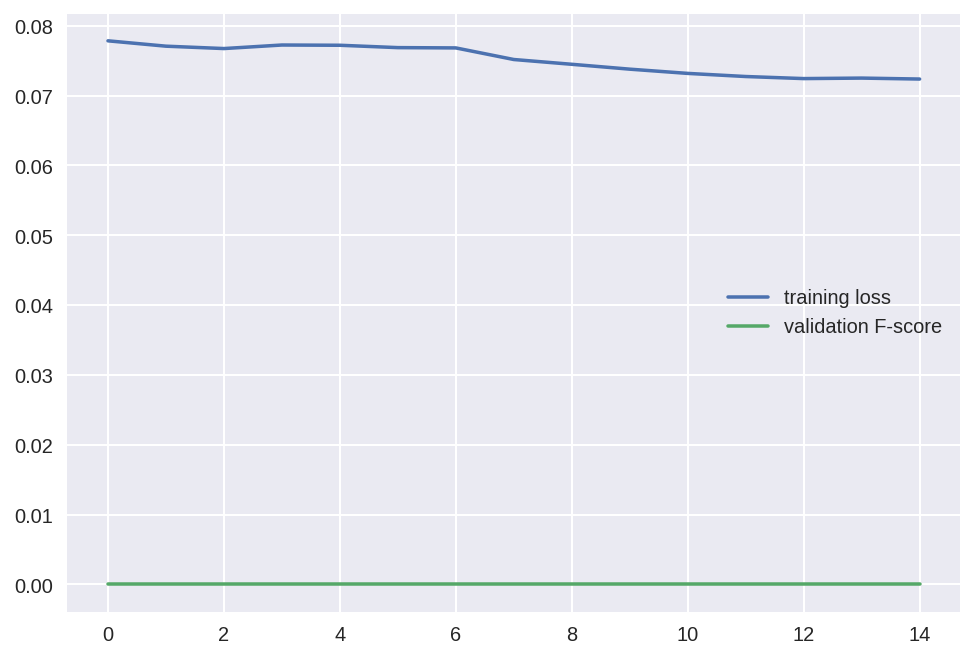

In [30]:
train(train_examples, valid_examples, embvec, TEXT, LABEL, device, model0, batch_size, optimizer,n_epochs)

In [17]:
torch.save(model0.state_dict(), '/home/pding/OneDrive/kph/kph/lstmcrflow.pt')

In [31]:
torch.save(model0.state_dict(), '/home/pding/OneDrive/kph/kph/lstmcr724.pt')

In [63]:
model0.load_state_dict(torch.load('/home/pding/OneDrive/kph/kph/lstmcrf.pt'))

RuntimeError: Error(s) in loading state_dict for RNNCRFTagger:
	size mismatch for rnn.weight_ih_l0: copying a param with shape torch.Size([384, 300]) from checkpoint, the shape in current model is torch.Size([512, 300]).
	size mismatch for rnn.weight_hh_l0: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for rnn.bias_ih_l0: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for rnn.bias_hh_l0: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for rnn.weight_ih_l0_reverse: copying a param with shape torch.Size([384, 300]) from checkpoint, the shape in current model is torch.Size([512, 300]).
	size mismatch for rnn.weight_hh_l0_reverse: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for rnn.bias_ih_l0_reverse: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for rnn.bias_hh_l0_reverse: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).

In [49]:
class Tagger:
    
    def __init__(self, lower):
        self.TEXT = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, lower=lower)
        self.LABEL = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, unk_token=None)
        self.fields = [('text', self.TEXT), ('label', self.LABEL)]
        self.device = 'cuda'
        
    def tag(self, sentences):
        # This method applies the trained model to a list of sentences.
        
        # First, create a torchtext Dataset containing the sentences to tag.
        examples = []
        for sen in sentences:
            labels = ['O']*len(sen) # placeholder
            examples.append(torchtext.data.Example.fromlist([sen, labels], self.fields))
        dataset = torchtext.data.Dataset(examples, self.fields)
        
        iterator = torchtext.data.Iterator(
            dataset,
            device=self.device,
            batch_size=64,
            repeat=False,
            train=False,
            sort=False)
        
        # Apply the trained model to all batches.
        out = []
        self.model.eval()
        with torch.no_grad():
            for batch in iterator:
                # Call the model's predict method. This returns a list of NumPy matrix
                # containing the integer-encoded tags for each sentence.
                predicted = self.model.predict(batch.text)

                # Convert the integer-encoded tags to tag strings.
                for tokens, pred_sen in zip(sentences, predicted):
                    out.append([self.LABEL.vocab.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
        return out
                
    def train(self):
        # Read training and validation data according to the predefined split.
        train_examples = read_data(df_train, self.fields)
        valid_examples = read_data(df_val, self.fields)

        # Count the number of words and sentences.
        n_tokens_train = 0
        n_sentences_train = 0
        for ex in train_examples:
            n_tokens_train += len(ex.text) + 2
            n_sentences_train += 1
        n_tokens_valid = 0       
        for ex in valid_examples:
            n_tokens_valid += len(ex.text)

        # Load the pre-trained embeddings that come with the torchtext library.
        use_pretrained = True
        if use_pretrained:
            print('We are using pre-trained word embeddings.')
            self.TEXT.build_vocab(train_examples, vectors=embvec)
        else:  
            print('We are training word embeddings from scratch.')
            self.TEXT.build_vocab(train_examples, max_size=5000)
        self.LABEL.build_vocab(train_examples)
    
        # Create one of the models defined above.
        #self.model = RNNTagger(self.TEXT, self.LABEL, emb_dim=300, rnn_size=128, update_pretrained=False)
        self.model = RNNCRFTagger(self.TEXT, self.LABEL, emb_dim=300, rnn_size=128, update_pretrained=False)
    
        self.model.to(self.device)
    
        batch_size = 310
        n_batches = np.ceil(n_sentences_train / batch_size)

        mean_n_tokens = n_tokens_train / n_batches

        train_iterator = torchtext.data.BucketIterator(
            train_examples,
            device=self.device,
            batch_size=batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            train=True,
            sort=True)

        valid_iterator = torchtext.data.BucketIterator(
            valid_examples,
            device=self.device,
            batch_size=64,
            sort_key=lambda x: len(x.text),
            repeat=False,
            train=False,
            sort=True)
    
        train_batches = list(train_iterator)
        valid_batches = list(valid_iterator)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01, weight_decay=1e-5)

        n_labels = len(self.LABEL.vocab)

        history = defaultdict(list)    
        
        n_epochs = 15
        
        for i in range(1, n_epochs + 1):

            t0 = time.time()

            loss_sum = 0

            self.model.train()
            for batch in train_batches:
                
                # Compute the output and loss.
                loss = self.model(batch.text, batch.label) / mean_n_tokens
                
                optimizer.zero_grad()            
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

            train_loss = loss_sum / n_batches
            history['train_loss'].append(train_loss)

            # Evaluate on the validation set.
            if i % 1 == 0:
                stats = defaultdict(Counter)

                self.model.eval()
                with torch.no_grad():
                    for batch in valid_batches:
                        # Predict the model's output on a batch.
                        predicted = self.model.predict(batch.text)                   
                        # Update the evaluation statistics.
                        evaluate_iob(predicted, batch.label, self.LABEL, stats)
            
                # Compute the overall F-score for the validation set.
                _, _, val_f1 = prf(stats['total'])
                
                history['val_f1'].append(val_f1)
            
                t1 = time.time()
                print(f'Epoch {i}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')
           
        # After the final evaluation, we print more detailed evaluation statistics, including
        # precision, recall, and F-scores for the different types of named entities.
        print()
        print('Final evaluation on the validation set:')
        p, r, f1 = prf(stats['total'])
        print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        for label in stats:
            if label != 'total':
                p, r, f1 = prf(stats[label])
                print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        
        plt.plot(history['train_loss'])
        plt.plot(history['val_f1'])
        plt.legend(['training loss', 'validation F-score'])


In [51]:
tagger = Tagger(lower=False)
#tagger.train()

In [19]:
def tagger2(sentences, model):
    # This method applies the trained model to a list of sentences.

    # First, create a torchtext Dataset containing the sentences to tag.
    examples = []
    for sen in sentences:
        words = tokenizersrc(sen)
        labels = ['O']*len(words) # placeholder
        examples.append(torchtext.data.Example.fromlist([words, labels], fields))
    dataset = torchtext.data.Dataset(examples, fields)

    iterator = torchtext.data.Iterator(
        dataset,
        device=device,
        batch_size=64,
        repeat=False,
        train=False,
        sort=False)

    # Apply the trained model to all batches.
    out = []
    model.eval()
    for batch in iterator:
        # Call the model's predict method. This returns a list of NumPy matrix
        # containing the integer-encoded tags for each sentence.
        predicted = model.predict(batch.text)

        # Convert the integer-encoded tags to tag strings.
        #for tokens, pred_sen in zip(sentences, predicted):
        for tokens, pred_sen in zip(sentences, predicted):
            out.append([LABEL.vocab.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
    return out

In [41]:
def kphext(sentences,tags):
    kph = []
    for i in range(len(sentences)):
        s0 = svoc.tokenizer(sentences[i])
        s1 = [tok.text for tok in s0]
        t1 = tags[i]
        k1 = []
        for j in range(len(s1)):
            if t1[j] == 'O':
                k2 = ''
            if t1[j] == 'B':
                k2 = str(s1[j])
                try: 
                    kt = t1[j+1]
                    if kt == 'B':
                        k1.append(k2)
                    if kt == 'O':
                        k1.append(k2)
                except(AttributeError, TypeError):
                    pass
            if t1[j] == 'I':
                k2 = k2 + ' '+str(s1[j])
                try: 
                    kt = t1[j+1]
                    if kt == 'B':
                        k1.append(k2)
                    if kt == 'O':
                        k1.append(k2)
                except(AttributeError, TypeError):
                    pass
        kph.append(k1)
    return kph

In [358]:
def kphext2(sentences,tags):
    kph = []
    for i in range(len(sentences)):
        s0 = svoc.tokenizer(sentences[i])
        s1 = [tok.text for tok in s0]
        t1 = tags[i]
        k1 = []
        for j in range(len(s1)):
            start = j
            if t1[j] == 'B':
                sti = 0
                stop = j+1
                while sti == 0:
                    try: 
                        kt = str(t1[stop])
                        if kt == 'I':
                            stop = stop+1
                        else:
                            k2 = str(s0[start:stop])
                            k1.append(k2)
                            sti =1
                    except(IndexError):
                        k2 = s0[start:stop]
                        k1.append(k2)
                        sti =1
                k2 = str(s1[j])
        kph.append(k1)
    return kph

In [55]:
tagger.train_examples

AttributeError: 'Tagger' object has no attribute 'train_examples'

In [163]:
sentences1 = ['Case studies illustrating the management of trigeminal neuropathic pain using topical 5% lidocaine plasters. Chronic trigeminal pain, with its severe related functional problems, is difficult to treat. Treatment is often empirically based on medications used for other chronic pain conditions. Systemic sodium channel and calcium channel blocking agents may cause a multitude of complications that are often poorly tolerated by the patient.\nThe aim of this case report was to assess the efficacy of topical 5% lidocaine plasters in reducing pain and reducing adjuvant medication in patients with orofacial neuropathic pain.\nFourteen patients with chronic orofacial pain conditions referred to the oral surgery department were instructed to wear 5% lidocaine plasters for 12 hours each day over the painful area. The conditions included post-surgical neuropathy (n = 10), multiple sclerosis-related pain (n = 1), persistent idiopathic facial pain (n = 1), Ramsay Hunt syndrome (post-herpetic neuralgia, n = 1) and trigeminal neuralgia (n = 1). Data were collected on patient demographics, pain levels and medication.\nPain levels improved in 12 out of 14 patients. Nine patients had a reduction in adjuvant medication, two of whom completely stopped adjuvant treatment.\nThis case series demonstrates that of the use of 5% lidocaine plasters may play a useful role in the management of chronic trigeminal pain. A suggested novel approach for the management of orofacial pain, for clinicians, is presented.\nManagement of chronic orofacial pain continues to be a major challenge to the clinician.Patients are often placed on a multitude of medications in an attempt to alleviate pain without success.Topical 5% lidocaine plasters, currently used for the management of post-herpetic neuralgia, offer the option of locally targeting trigeminal pain without the multiple side-effects of systemic medication.This case series demonstrates that lidocaine plasters decrease verbal pain scores in extraoral, trigeminal and neuropathic pain, and reduce the use of other neuromodulatory agents in some, but not all, patients.The plasters should be considered as a useful adjuvant in the management of pain in these patients.This case series demonstrates that of the use of 5% lidocaine plasters may play a useful role in the management of chronic trigeminal pain. A suggested novel approach for the management of orofacial pain, for clinicians, is presented.Fourteen patients with chronic orofacial pain conditions referred to the oral surgery department were instructed to wear 5% lidocaine plasters for 12 hours each day over the painful area. The conditions included post-surgical neuropathy (n = 10), multiple sclerosis-related pain (n = 1), persistent idiopathic facial pain (n = 1), Ramsay Hunt syndrome (post-herpetic neuralgia, n = 1) and trigeminal neuralgia (n = 1). Data were collected on patient demographics, pain levels and medication.Pain levels improved in 12 out of 14 patients. Nine patients had a reduction in adjuvant medication, two of whom completely stopped adjuvant treatment.' ,"The dichotomous role of the gut microbiome in exacerbating and ameliorating neurodegenerative disorders. Age related neurodegenerative disorders affect millions of people around the world. The role of the gut microbiome (GM) in neurodegenerative disorders has been elucidated over the past few years. Dysbiosis of the gut microbiome ultimately results in neurodegeneration. However, the gut microbiome can be modulated to promote neuro-resilience.\nThis review is focused on demonstrating the role of the gut microbiome in host physiology in Parkinson's disease (PD) and other neurodegenerative disorders. We will discuss how the microbiome will impact neurodegeneration in PD, Alzheimer's Disease (AD), Multiple sclerosis (MS), Amyotrophic Lateral Sclerosis (ALS), and finally discuss how the gut microbiome can be influenced through diet and lifestyle.\nCurrently, much of the focus has been to study the mechanisms by which the microbiome induces neuroinflammation and neurodegeneration in PD, AD, MS, ALS. In particular, the role of certain dietary flavonoids in regulation of gut microbiome to promote neuro-resilience. Polyphenol prebiotics delivered in combination with probiotics (synbiotics) present an exciting new avenue to harness the microbiome to attenuate immune inflammatory responses which ultimately may influence brain cascades associated with promotion of neurodegeneration across the lifespan."]

In [169]:
sentences0 = ["The dichotomous role of the gut microbiome in exacerbating and ameliorating neurodegenerative disorders. Age related neurodegenerative disorders affect millions of people around the world. The role of the gut microbiome (GM) in neurodegenerative disorders has been elucidated over the past few years. Dysbiosis of the gut microbiome ultimately results in neurodegeneration. However, the gut microbiome can be modulated to promote neuro-resilience.\nThis review is focused on demonstrating the role of the gut microbiome in host physiology in Parkinson's disease (PD) and other neurodegenerative disorders. We will discuss how the microbiome will impact neurodegeneration in PD, Alzheimer's Disease (AD), Multiple sclerosis (MS), Amyotrophic Lateral Sclerosis (ALS), and finally discuss how the gut microbiome can be influenced through diet and lifestyle.\nCurrently, much of the focus has been to study the mechanisms by which the microbiome induces neuroinflammation and neurodegeneration in PD, AD, MS, ALS. In particular, the role of certain dietary flavonoids in regulation of gut microbiome to promote neuro-resilience. Polyphenol prebiotics delivered in combination with probiotics (synbiotics) present an exciting new avenue to harness the microbiome to attenuate immune inflammatory responses which ultimately may influence brain cascades associated with promotion of neurodegeneration across the lifespan."]

In [170]:
tagss2 = tagger2(sentences0,model0)

In [146]:
test_ex

NameError: name 'trainexaples' is not defined

In [116]:
tt1 = kphext2(sentences,tagss)

In [167]:
tagss

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'I',
  'O',
  'O',
  'O',
  'O',
  'B',
  'O',
  'O',
  'B',
  'I',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'O',
  'O',
  'O',
  'B',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'I',
  'I',
  'O',
  'O',
  'O',

In [168]:
len(tagss)

2

In [39]:
tagss = tagger2(sentences)

In [13]:
torch.save(tagger.model.state_dict(), './kph/lstmcrf.pt')

In [37]:
A11 = svoc.tokenizer('neuro - resilience')

In [40]:
''.join(token.text_with_ws for token in A11)

'neuro - resilience'

In [106]:
tt2 = datatrain.iloc[3,:].keywords

In [107]:
tt2

['Alzheimer’s disease',
 'Parkinson’s disease',
 'gut dysbiosis',
 'gut microbiome',
 'neuro-resilience',
 'neurodegenerative disorders',
 'polyphenols',
 'probiotics',
 'synbiotics']

In [128]:
k = 0
for kp in tt2:
    if kp.lower() in [x.lower() for x in tt1[0]]:
        print(kp)
        k = k+1

gut microbiome
neuro-resilience


In [129]:
tt2[1].lower()

'parkinson’s disease'

In [135]:
tt1[0][6].lower()

"parkinson's disease"

In [137]:
tt2[1]

'Parkinson’s disease'

In [139]:
tt1[0][6]

"Parkinson's disease"

In [142]:
svoc(tt2[1])

Parkinson’s disease

In [145]:
datatrain.iloc[3,:].SRC

"The dichotomous role of the gut microbiome in exacerbating and ameliorating neurodegenerative disorders. Age related neurodegenerative disorders affect millions of people around the world. The role of the gut microbiome (GM) in neurodegenerative disorders has been elucidated over the past few years. Dysbiosis of the gut microbiome ultimately results in neurodegeneration. However, the gut microbiome can be modulated to promote neuro-resilience.\nThis review is focused on demonstrating the role of the gut microbiome in host physiology in Parkinson's disease (PD) and other neurodegenerative disorders. We will discuss how the microbiome will impact neurodegeneration in PD, Alzheimer's Disease (AD), Multiple sclerosis (MS), Amyotrophic Lateral Sclerosis (ALS), and finally discuss how the gut microbiome can be influenced through diet and lifestyle.\nCurrently, much of the focus has been to study the mechanisms by which the microbiome induces neuroinflammation and neurodegeneration in PD, AD

In [161]:
def evaltest(valid_examples, df_val_k, model):
    # This method applies the trained model to a list of sentences.
    
    # First, create a torchtext Dataset containing the sentences to tag.
    iterator = torchtext.data.BucketIterator(
        valid_examples,
        device=device,
        batch_size=64,
        repeat=False,
        train=False,
        sort=False)

    # Apply the trained model to all batches.
    out = []
    model.eval()
    for batch in iterator:
        # Call the model's predict method. This returns a list of NumPy matrix
        # containing the integer-encoded tags for each sentence.
        predicted = model.predict(batch.text)

        # Convert the integer-encoded tags to tag strings.
        #for tokens, pred_sen in zip(sentences, predicted):
        for tokens, pred_sen in zip(sentences, predicted):
            out.append([LABEL.vocab.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
    return out

In [259]:
def evaltest2(df_val, df_val_k, model):
    # This method applies the trained model to a list of sentences.
    examples = []
    for sen in df_val.SRC:
        words = tokenizersrc(sen)
        labels = ['O']*len(words) # placeholder
        examples.append(torchtext.data.Example.fromlist([words, labels], fields))
    dataset = torchtext.data.Dataset(examples, fields)

    iterator = torchtext.data.Iterator(
        dataset,
        device=device,
        batch_size=1,
        repeat=False,
        train=False,
        sort=False)

    # Apply the trained model to all batches.
    out = []
    model.eval()
    for batch in iterator:
        # Call the model's predict method. This returns a list of NumPy matrix
        # containing the integer-encoded tags for each sentence.
        predicted = model.predict(batch.text)

        # Convert the integer-encoded tags to tag strings.
        #for tokens, pred_sen in zip(sentences, predicted):
        for tokens, pred_sen in zip(batch.text.view(1,-1), predicted):
            out.append([LABEL.vocab.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
    return out

In [155]:
out1 = evaltest(valid_examples, df_val_k, model0)

In [260]:
out2 = evaltest2(df_val, df_val_k, model0)

In [332]:
def tagperct(df_val,out):
    tp = np.empty(len(out))
    for i in range(len(df_val.index)):
        trg = tokenizertrg(df_val.iloc[i,1])
        total = 0
        for x in trg:
            if x != 'O':
                total = total+1
        matched = 0
        for j in range(total):
            if trg[j] != 'O':
                if trg[j]== out[i][j]:
                    matched = matched +1
        p = matched/total
        tp[i] = p
    return tp
        

In [ ]:
outags2 = kphext2(sentences,tagss)

In [384]:
def kphperct(df_val_k,out):
    tp = np.empty(len(out))
    for i in range(len(df_val_k.index)):
        ktrg = df_val_k.iloc[i,2]
        pred = kphext2([df_val_k.iloc[i,0]],[out[i]])
        k = 0
        for kp in ktrg:
            if str(kp).lower() in [str(x).lower() for x in pred[0]]:
                k = k+1
        tp[i] = k/len(ktrg)
    return tp

In [381]:
ktrg = df_val_k.iloc[0,2]
pred = kphext2([df_val_k.iloc[0,0]],[out2[0]])
k = 0
for kp in ktrg:
    if str(kp).lower() in [str(x).lower() for x in pred[0]]:
        print(kp)
        k = k+1

lidocaine
pain


In [382]:
ktrg

['Chronic', 'lidocaine', 'neuropathic', 'pain', 'topical', 'trigeminal']

In [383]:
pred

[['trigeminal neuropathic pain',
  'lidocaine',
  'Chronic trigeminal pain',
  'Systemic sodium channel',
  'lidocaine',
  'pain',
  'neuropathic pain',
  'oral surgery',
  'post-surgical neuropathy',
  'facial pain',
  'post-herpetic neuralgia',
  'Pain',
  'lidocaine',
  'chronic trigeminal pain',
  'post-herpetic neuralgia',
  'trigeminal pain',
  'neuropathic pain',
  'lidocaine',
  'trigeminal pain',
  'oral surgery',
  'post-surgical neuropathy',
  'facial pain']]

In [ ]:
sentences = [df_val_k.iloc[1,0]]

In [ ]:
tags = 

In [367]:
ttp.mean()

0.9392870656305853

In [333]:
ttp2 = tagperct(df_val,out2)

In [335]:
ttp2.mean()

0.15309184079214003

In [385]:
ttp3 = kphperct(df_val_k,out2)

In [388]:
ttp3.mean()

0.3915932524942566

In [378]:
ttp3.mean()

0.024907155236444666

In [330]:
for x in trg:
    if x != 'O':
        total = total+1


In [331]:
total

10

In [349]:
df_val.iloc[1,1].

'B O O B O O O O O O O O O O B B O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O B O O B B O O O O O O O O O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B B O O O O O O O O O O O O O O O O O O O O O O O O B O O B O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

In [275]:
df_val

,SRC,TRG
26516508,Case studies illustrating the management of tr...,O O O O O O B B B O B O O B O O B B B O O O O ...
31374461,Cognitive and brain reserve in multiple sclero...,B O O B O O O O O O O O O O B B O O O O O O O ...
27717695,B cells of multiple sclerosis patients induce ...,B I O B I O O O O O O O O O O O O O O O O O O ...
31602359,2019 European Thyroid Association Guidelines o...,O B B I B O O B O B O O B I O O B O O O O O O ...
24419020,"Caregiver burden, quality of life and walking ...",B B O B I I O O O O O B O O B I O O O O B I O ...
...,...,...
27472871,TRAIL gene expression analysis in multiple scl...,B B I O O B I O O B I O O O O O O O O O O O O ...
24347169,Ninjurin1 deficiency attenuates susceptibility...,B O O O O O O O O O O B O O O O O O O O B I O ...
27631876,High-Resolution Expression Profiling of Periph...,O O O O O O B I O B O O B O O O O O O O O O O ...
25326018,Effects of coenzyme Q10 on the ratio of TH1/TH...,O O B I O O O O O O O O B I I O O B I O O O B ...
